<a href="https://colab.research.google.com/github/darrencheninfo/ADS504_G1_Project/blob/main/ADS504_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

This is an exploration of the CDCS Behavorial Risk Factor Surveillence System Dataset, 2024. The objective of this study is to predict the likelihood of a chronic condition based on lifestyle indicators. The goal is to be able to provide interventive education to prevent comorbidities based on health risk indicators.

## Setup

### Get Libraries

In [3]:
%pip install --upgrade numpy scipy
%pip install --upgrade cupy
%pip install missingno

import numpy
print(numpy.__file__)
print(numpy.__version__)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.5 MB 682.7 kB/s eta 0:00:06
      --------------------------------------- 0.1/3.5 MB 656.4 kB/s eta 0:00:06
     - -------------------------------------- 0.1/3.5 MB 991.0 kB/s eta 0:00:04
     ---- ----------------------------------- 0.4/3.5 MB 2.1 MB/s eta 0:00:02
     ------ --------------------------------- 0.6/3.5 MB 2.7 MB/s eta 0:00:02
     --------- ------------------------------ 0.9/3.5 MB 3.2 MB/s eta 0:00:01
     ------------- -------------------------- 1.1/3.5 MB 3.8 MB/s eta 0:00:01
     ---------------- ----------------------- 1.5/3.5 MB 4.3 MB/s eta 0:00:01
     --------------------- ------------------ 1.9/3.5 MB 4.6 MB/s eta 0:00:01
     -------------------------- ------------- 2.3/3.5 MB 5.0 MB/s eta 0:00:01
     ------------------------------ --------- 2.7/3.5 MB 5.6 MB/s eta 0:00:01

  error: subprocess-exited-with-error
  
  × Building wheel for cupy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [68 lines of output]
      Clearing directory: C:\Users\darre\AppData\Local\Temp\pip-install-vha24zoa\cupy_61378798aa9443e3b4047a9d1aeb43a2\cupy\.data
      Generating CUPY_CACHE_KEY from header files...
      CUPY_CACHE_KEY (1729 files matching C:\Users\darre\AppData\Local\Temp\pip-install-vha24zoa\cupy_61378798aa9443e3b4047a9d1aeb43a2\cupy\_core\include\**): 62426478e3e7017e0abfdd71b0667fdffa294302
      Looking for NVTX: C:\Program Files\NVIDIA Corporation\Nsight Systems *\target-windows-x64\nvtx
      NVTX could not be found
      
      -------- Configuring Module: cuda --------
      Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      **************************************************
      *** WARNING: Cannot check compute capability
      Micr

Note: you may need to restart the kernel to use updated packages.
c:\Users\darre\miniconda3\envs\ads502\lib\site-packages\numpy\__init__.py
2.2.6


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Dataset

In [1]:
#import dataset
# df = pd.read_sas('/content/drive/MyDrive/ADS 504 | Final Project/LLCP2023.XPT ', format='xport') # replace with your dataset path
df = pd.read_sas('raw_data\LLCP2023.XPT ', format='xport')

NameError: name 'pd' is not defined

In [ ]:
df.shape

(433323, 350)

## Refine Dataset to isolate to Type II Diabetes

In [ ]:
df2 = df[df['DIABTYPE'] == 2]
df2.shape

(20069, 350)

In [ ]:
#What combos do we have for DIABETES & DIABETYPE, ensure no errors
combo_counts = (
    df2
    .groupby(['DIABETE4', 'DIABTYPE'])
    .size()
    .reset_index(name='count')
    .sort_values(['count'], ascending=False)
)
print(combo_counts)

   DIABETE4  DIABTYPE  count
0       1.0       2.0  20069


##  Organize 350 Features into Types

In [ ]:
sections = {
    "Record_Identification": ['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE', 'SEQNO', '_PSU'],
    "Phone_Introduction": ['CTELENM1', 'CELPHON1', 'PVTRESD1','COLGHOUS', 'STATERE1', 'LADULT1', 'NUMADULT','RESPSLC1', 'LANDSEX2','SAFETIME', 'CTELNUM1', 'CELLFON5', 'CADULT1', 'CELLSEX2', 'PVTRESD3', 'CCLGHOUS', 'CSTATE1',
    'LANDLINE', 'HHADULT'],
    'Respondent_Sex': ['SEXVAR'],
    'Health_Status': ['GENHLTH'],
    'Healthy_Days': ['PHYSHLTH', 'MENTHLTH', 'POORHLTH'],
    'Healthcare_Access': ['PRIMINS1', 'PERSDOC3','MEDCOST1', 'CHECKUP1'],
    'Exercise' : ['EXERANY2', 'EXRACT12', 'EXEROFT1', 'EXERHMM1', 'EXRACT22', 'EXEROFT2', 'EXERHMM2', 'STRENGTH'],
    'Hypertension_Awareness': ['BPHIGH6', 'BPMEDS1'],
    'Cholestrol_Awareness': ['CHOLCHK3', 'TOLDHI3', 'CHOLMED3'],
    'Chronic_Health_Conditions': ['CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1',
                                  'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'DIABAGE4'],
    'Demographics': ['MARITAL', 'EDUCA', 'RENTHOM1', 'NUMHHOL4', 'NUMPHON4', 'CPDEMO1C', 'VETERAN3', 'EMPLOY1',
                     'CHILDREN','INCOME3', 'PREGNANT', 'WEIGHT2', 'HEIGHT3'],
    'Disability': ['DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON'],
    'Falls': ['FALL12MN', 'FALLINJ5'],
    'Tobacco_Use': ['SMOKE100', 'SMOKDAY2', 'USENOW3', 'ECIGNOW2'],
    'Alcohol_Consumption': ['ALCDAY4', 'AVEDRNK3', 'DRNK3GE5', 'MAXDRNKS'],
    'Immunization': ['FLUSHOT7', 'FLSHTMY3', 'PNEUVAC4', 'SHINGLE2', 'HIVTST7', 'HIVTSTD3'],
    'Seatbelt_Use_Drinking_and_Driving': ['SEATBELT', 'DRNKDRI2'],
    'Long_Term_Covid_Effects': ['COVIDPO1', 'COVIDSM1', 'COVIDACT'],
    'Pre_Diabetes': ['PDIABTS1', 'PREDIAB2'],
    'Diabetes': ['DIABTYPE', 'INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'DIABEYE1', 'DIABEDU1','FEETSORE'],
    'Arthritis': ['ARTHEXER', 'ARTHEDU', 'LMTJOIN3', 'ARTHDIS2', 'JOINPAI2'],
    'Lung_Cancer_Screening': ['LCSFIRST','LCSLAST', 'LCSNUMCG', 'LCSCTSC1', 'LCSSCNCR', 'LCSCTWHN'],
    'Breast_and_Cervical_Cancer_Screening': ['HADMAM', 'HOWLONG', 'CERVSCRN', 'CRVCLCNC', 'CRVCLPAP', 'CRVCLHPV',
                                             'HADHYST2'],
    'Prostate_Cancer_Screening': ['PSATEST1', 'PSATIME1', 'PCPSARS2', 'PSASUGS1', 'PCSTALK2'],
    'Colorectal_Cancer_Screening': ['HADSIGM4', 'COLNSIGM', 'COLNTES1', 'SIGMTES1', 'LASTSIG4', 'COLNCNCR', 'VIRCOLO1',
                                    'VCLNTES2', 'SMALSTOL', 'STOLTEST', 'STOOLDN2', 'BLDSTFIT', 'SDNATES1'],
    'Cancer_Survivorship': ['CNCRDIFF', 'CNCRAGE', 'CNCRTYP2', 'CSRVTRT3', 'CSRVDOC1', 'CSRVSUM', 'CSRVRTRN', 'CSRVINST',
                            'CSRVINSR', 'CSRVDEIN', 'CSRVCLIN', 'CSRVPAIN', 'CSRVCTL2'],
    'Indoor_Tanning': ['INDORTAN'],
    'Excess_Sun_Exposure': ['NUMBURN3', 'SUNPRTCT', 'WKDAYOUT', 'WKENDOUT'],
    'Cognitive Decline': ['CIMEMLO1', 'CDWORRY', 'CDDISCU1', 'CDHOUS1', 'CDSOCIA1'],
    'Caregiver': ['CAREGIV1', 'CRGVREL4', 'CRGVLNG1', 'CRGVHRS1', 'CRGVPRB3', 'CRGVALZD', 'CRGVPER1', 'CRGVHOU1', 'CRGVEXPT'],
    'Tobacco_Cessation': ['LASTSMK2', 'STOPSMK2', 'MENTCIGS', 'MENTECIG', 'HEATTBCO'],
    'Firearm_Safety': ['FIREARM5', 'GUNLOAD', 'LOADULK2'],
    'Heart_Attack_And_Stroke': ['HASYMP1', 'HASYMP2', 'HASYMP3', 'HASYMP4', 'HASYMP5','HASYMP6', 'STRSYMP1', 'STRSYMP2',
                                'STRSYMP3', 'STRSYMP4', 'STRSYMP5', 'STRSYMP6', 'FIRSTAID'],
    'Aspirin_for_CVD_Prevention': ['ASPIRIN'],
    'Sexual_Orientation': ['SOMALE', 'SOFEMALE'],
    'Marijuana_Use': ['MARIJAN1', 'MARJSMOK', 'MARJEAT', 'MARJVAPE', 'MARJDAB', 'MARJOTHR'],
    'Adverse_Childhood_Experiences': ['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN','ACEDIVRC', 'ACEPUNCH', 'ACEHURT1',
                                      'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX', 'ACEADSAF', 'ACEADNED'],
    'Place_of_Flu_Vaccination': ['IMFVPLA4'],
    'HPV_Vaccination': ['HPVADVC4', 'HPVADSHT'],
    'Tetanus_Diptheria': ['TETANUS1'],
    'COVID_Vaccination': ['COVIDVA1', 'COVACGE1', 'COVIDNU2'],
    'Social_Determinants': ['LSATISFY', 'EMTSUPRT', 'SDLONELY', 'SDHEMPLY', 'FOODSTMP', 'SDHFOOD1', 'SDHBILLS', 'SDHUTILS',
                            'SDHTRNSP', 'SDHSTRE1'],
    'Reactions_to_Race': ['RRCLASS3', 'RRCOGNT2', 'RRTREAT', 'RRATWRK2', 'RRHCARE4', 'RRPHYSM2'],
    'Random_Child_Selection': ['RCSBORG1', 'RCSRLTN2'],
    'Childhood_Asthma_Prevalance': ['CASTHDX2', 'CASTHNO2'],
    'Questionnaire_Version': ['QSTVER'],
    'Questionaire_Language': ['QSTLANG'],
    'Urban_Rural': ['_METSTAT', '_URBSTAT'],
    'Weighting_Variables': ['MSCODE', '_STSTR', '_STRWT', '_RAWRAKE', '_WT2RAKE', '_IMPRACE', '_DUALUSE', '_DUALCOR',
                            '_LLCPWT2', '_LLCPWT'],
    'Child_Demographic_Variables': ['_CHISPNC', '_CRACE1'],
    'Child_Weighting_Variables': ['CAGEG', '_CLLCPWT'],
    'Calculated_Variables': ['_PHYS14D', '_MENT14D', '_HLTHPL1', '_HCVU653', '_TOTINDA', 'METVL12_', 'METVL22_','MAXVO21_',
                              'FC601_', 'ACTIN13_', 'ACTIN23_', 'PADUR1_', 'PADUR2_', 'PAFREQ1_', 'PAFREQ2_', '_MINAC12',
                             '_MINAC22', 'STRFREQ_', 'PAMISS3_', 'PAMIN13_', 'PAMIN23_', 'PA3MIN_', 'PAVIG13_','PAVIG23_',
                             'PA3VIGM_', '_PACAT3', '_PAINDX3', '_PA150R4', '_PA300R4', '_PA30023', '_PASTRNG', '_PAREC3',
                             '_PASTAE3', '_RFHYPE6', '_CHOLCH3', '_RFCHOL3', '_MICHD', '_LTASTH1', '_CASTHM1', '_ASTHMS1',
                             '_DRDXAR2', '_SEX', '_AGEG5YR', '_AGE65YR', '_AGE80', '_AGE_G', 'HTIN4', 'HTM4', 'WTKG3', '_BMI5',
                             '_BMI5CAT', '_RFBMI5', '_CHLDCNT', '_EDUCAG', '_INCOMG1', '_SMOKER3', '_RFSMOK3', '_CURECI2',
                             'DRNKANY6', 'DROCDY4_', '_RFBING6', '_DRNKWK2', '_RFDRHV8', '_FLSHOT7', '_PNEUMO3', '_AIDTST4',
                             '_RFSEAT2', '_RFSEAT3', '_DRNKDRV', '_RFHLTH'],
  'Calculated_Race_Variables' : ['_MRACE1', '_HISPANC', '_RACE', '_RACEG21', '_RACEGR3', '_RACEPRV'],
    'Uncategorized': ['LNDSXBRT', 'CELSXBRT', 'BIRTHSEX', 'TRNSGNDR', 'USEMRJN4', 'RCSGEND1', 'RCSXBRTH']
}


In [ ]:
# Build a set of all categorized variables via the dictionary
all_categorized = set().union(*sections.values())

# Identify any columns in df3 that were not categorized
uncategorized = [col for col in df2.columns if col not in all_categorized]
len(uncategorized)

0

In [ ]:
#create function to be able to call column names for different sections

def get_existing_cols(df, sections_dict, section_name):
    return [c for c in sections_dict.get(section_name, []) if c in df.columns]

## Drop Noise

### Drop by Section

In [ ]:
keep = ['_STATE', '_IMPRACE', "_AGE80"]

sections_to_drop = [
    "Adverse_Childhood_Experiences",
    "Arthritis",
    "Breast_and_Cervical_Cancer_Screening",
    "Calculated_Race_Variables",
    "Caregiver",
    "Cancer_Survivorship",
    "Child_Demographic_Variables",
    "Child_Weighting_Variables",
    "Cholestrol_Awareness",
    "Colorectal_Cancer_Screening",
    "Excess_Sun_Exposure",
    "Firearm_Safety",
    "Heart_Attack_And_Stroke",
    "Hypertension_Awareness",
    "Indoor_Tanning",
    "Long_Term_Covid_Effects",
    "Lung_Cancer_Screening",
    "Phone_Introduction",
    "Place_of_Flu_Vaccination",
    "Pre_Diabetes",
    "Prostate_Cancer_Screening",
    "Questionnaire_Version",
    "Random_Child_Selection",
    "Reactions_to_Race",
    "Record_Identification",
    "Sexual_Orientation",
    "Calculated_Variables",
    "Childhood_Asthma_Prevalance",
    "Uncategorized" ,
    "Weighting_Variables",
    "Questionaire_Language"

]

to_drop = [
    col
    for sec in sections_to_drop
    for col in sections.get(sec, [])
    if col not in keep
]

df3= df2.drop(columns=to_drop, errors='ignore')
df3.shape

(20069, 112)

In [ ]:
sections_pruned = {
    k: v
    for k, v in sections.items()
    if k not in sections_to_drop
}
display(sections_pruned)

{'Respondent_Sex': ['SEXVAR'],
 'Health_Status': ['GENHLTH'],
 'Healthy_Days': ['PHYSHLTH', 'MENTHLTH', 'POORHLTH'],
 'Healthcare_Access': ['PRIMINS1', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1'],
 'Exercise': ['EXERANY2',
  'EXRACT12',
  'EXEROFT1',
  'EXERHMM1',
  'EXRACT22',
  'EXEROFT2',
  'EXERHMM2',
  'STRENGTH'],
 'Chronic_Health_Conditions': ['CVDINFR4',
  'CVDCRHD4',
  'CVDSTRK3',
  'ASTHMA3',
  'ASTHNOW',
  'CHCSCNC1',
  'CHCOCNC1',
  'CHCCOPD3',
  'ADDEPEV3',
  'CHCKDNY2',
  'HAVARTH4',
  'DIABETE4',
  'DIABAGE4'],
 'Demographics': ['MARITAL',
  'EDUCA',
  'RENTHOM1',
  'NUMHHOL4',
  'NUMPHON4',
  'CPDEMO1C',
  'VETERAN3',
  'EMPLOY1',
  'CHILDREN',
  'INCOME3',
  'PREGNANT',
  'WEIGHT2',
  'HEIGHT3'],
 'Disability': ['DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON'],
 'Falls': ['FALL12MN', 'FALLINJ5'],
 'Tobacco_Use': ['SMOKE100', 'SMOKDAY2', 'USENOW3', 'ECIGNOW2'],
 'Alcohol_Consumption': ['ALCDAY4', 'AVEDRNK3', 'DRNK3GE5', 'MAXDRNKS'],
 'Immunization': ['FLUSHOT7',
 

### Drop by Column

In [ ]:
cols_to_drop = ['MENTHLTH', 'NUMHHOL4', 'NUMPHON4', 'CPDEMO1C', 'VETERAN3', 'PREGNANT', '_METSTAT', 'DIABTYPE', 'DIABETE4', 'SEATBELT']
df4 = df3.drop(columns=cols_to_drop, errors='ignore')
df4.shape

(20069, 102)

### Create Clean Dataframe

In [ ]:
diabetes_df = df4.copy()
diabetes_df.to_csv('/content/drive/MyDrive/ADS 504 | Final Project/diabetes_df.csv', index=False)

## Variable Exploration

In [ ]:
#create Data Quality Report function to be able to call for section-specific.


def dqr (df, cols):

    report = pd.DataFrame({
        'Feature': cols,
        'Count':           df[cols].count().values,
        'Missing Values':  df[cols].isnull().sum().values,
        'Cardinality':     df[cols].nunique().values,
        'Min':             df[cols].min().values,
        '1st Quartile':    df[cols].quantile(0.25).values,
        'Mean':            df[cols].mean().values,
        'Median':          df[cols].median().values,
        '3rd Quartile':    df[cols].quantile(0.75).values,
        'Max':             df[cols].max().values,
        'Std Dev':         df[cols].std().values,
    })
    return report

### Full Data Quality Report

In [ ]:
all_cols = df4.columns.tolist()
full_dq = dqr(df, all_cols)
pd.set_option('display.max_rows', 200)
full_dq

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Std Dev
0,SEXVAR,433323,0,2,1.0,1.0,1.529723,2.0,2.0,2.0,0.499116
1,GENHLTH,433319,4,7,1.0,2.0,2.629645,3.0,3.0,9.0,1.081803
2,PHYSHLTH,433320,3,33,1.0,14.0,58.477843,88.0,88.0,99.0,37.734401
3,POORHLTH,252170,181153,33,1.0,8.0,52.092521,88.0,88.0,99.0,38.793754
4,PRIMINS1,433318,5,13,1.0,1.0,10.865293,3.0,5.0,99.0,24.899418
5,PERSDOC3,433320,3,5,1.0,1.0,1.634589,1.0,2.0,9.0,0.909347
6,MEDCOST1,433321,2,4,1.0,2.0,1.933550,2.0,2.0,9.0,0.436001
7,CHECKUP1,433321,2,7,1.0,1.0,1.434567,1.0,1.0,9.0,1.136273
8,EXERANY2,433321,2,4,1.0,1.0,1.265353,1.0,1.0,9.0,0.548392
9,EXRACT12,325227,108096,13,1.0,1.0,4.241213,1.0,7.0,99.0,7.517496


### Respondent Sex

1 = Male, 2 = Female. This is somewhat evenly distributed with slightly more  female.

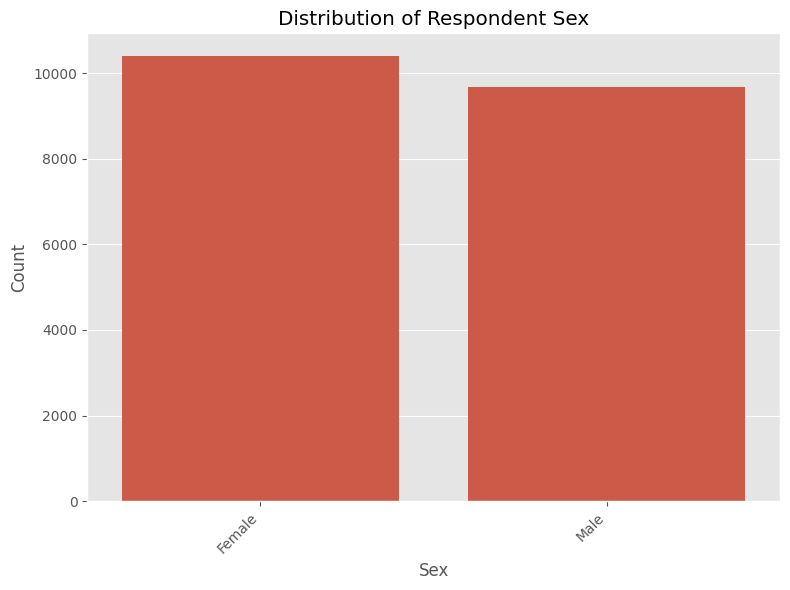

In [ ]:
df4['SEX_LABEL'] = df4['SEXVAR'].replace({1: 'Male', 2: 'Female'})

plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.countplot(x="SEX_LABEL", data=df4)
plt.title('Distribution of Respondent Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
print("percentage of each sex", df['SEXVAR'].value_counts()/len(df)*100)

percentage of each sex SEXVAR
2.0    52.972263
1.0    47.027737
Name: count, dtype: float64


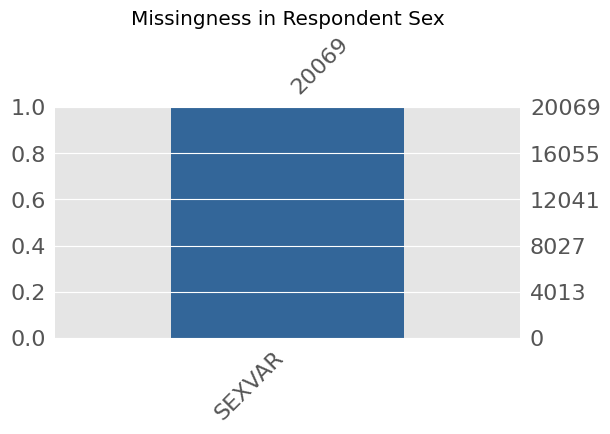

In [ ]:
col = get_existing_cols(df2, sections, 'Respondent_Sex')
msno.bar(df2[col],
         figsize=(6, 3),
         color=(0.2, 0.4, 0.6)
)
plt.title("Missingness in Respondent Sex")
plt.show()

### Rural vs Urban Demographic

1 = Urban,  2 = Rural. Significantly more representation by Rural.

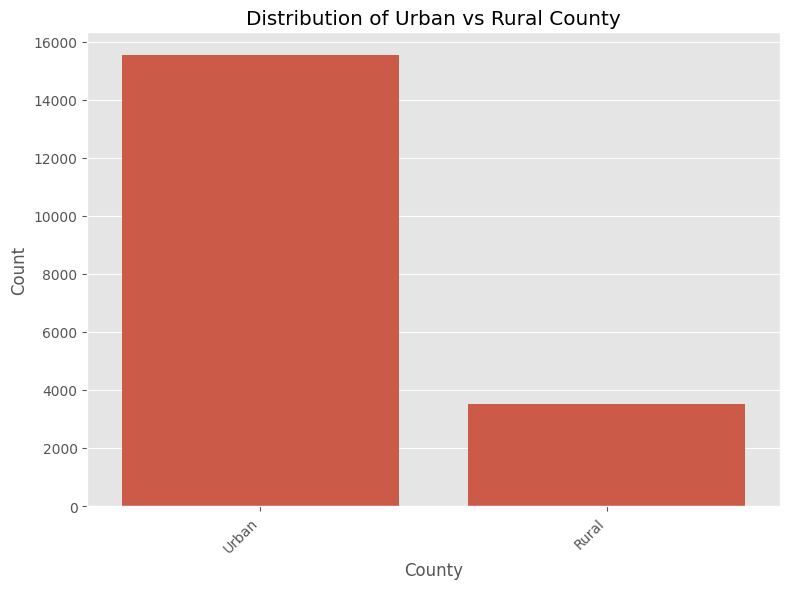

In [ ]:
df4['_URBSTAT'] = df4['_URBSTAT'].replace({1: 'Urban', 2: 'Rural'})

plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.countplot(x="_URBSTAT", data=df4)
plt.title('Distribution of Urban vs Rural County')
plt.xlabel('County')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
print("percentage of rural vs urban", df['_URBSTAT'].value_counts()/len(df)*100)

percentage of rural vs urban _URBSTAT
1.0    85.239648
2.0    12.839614
Name: count, dtype: float64


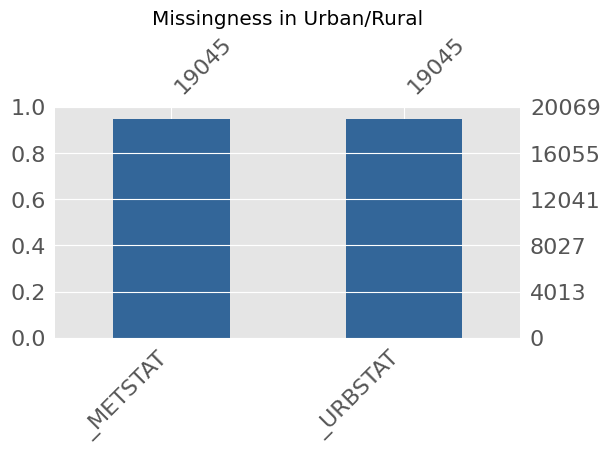

In [ ]:
col = get_existing_cols(df2, sections, 'Urban_Rural')
msno.bar(df2[col],
         figsize=(6, 3),
         color=(0.2, 0.4, 0.6)
)
plt.title("Missingness in Urban/Rural")
plt.show()

### States represented

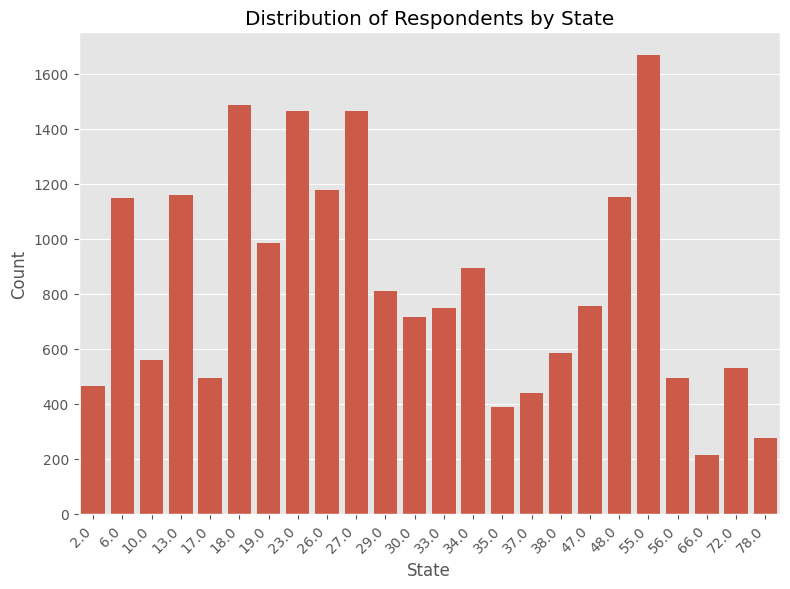

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.countplot(x= "_STATE", data=df4)
plt.title('Distribution of Respondents by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
print("percentage of state", df['_STATE'].value_counts()/len(df)*100)

percentage of state _STATE
53.0    6.102607
36.0    4.003711
24.0    3.982018
27.0    3.731627
39.0    3.088689
12.0    3.058919
31.0    2.973763
55.0    2.958301
23.0    2.828144
4.0     2.777605
6.0     2.763758
49.0    2.574061
18.0    2.536907
48.0    2.321363
45.0    2.316517
26.0    2.302670
20.0    2.280977
25.0    2.198822
9.0     2.192591
34.0    2.152667
19.0    2.048357
8.0     2.026894
13.0    1.898584
15.0    1.807428
50.0    1.762196
29.0    1.665963
30.0    1.648424
51.0    1.611038
33.0    1.606192
16.0    1.591192
40.0    1.552422
41.0    1.438650
46.0    1.358340
44.0    1.334109
38.0    1.325801
47.0    1.302723
2.0     1.275030
22.0    1.243414
5.0     1.234876
17.0    1.218260
72.0    1.060179
56.0    1.034794
1.0     1.006639
54.0    1.001332
10.0    0.988177
37.0    0.943407
28.0    0.939022
35.0    0.743095
11.0    0.740095
32.0    0.611553
78.0    0.476319
66.0    0.359778
Name: count, dtype: float64


State information is not meaningful in current display and will have to be re-coded. Highest state represented is 55 which is Wisconson. This is not representative of population samples within the United States. For example California (6.0) representation is significantly lower and New York (36) is not represented.

### Tobacco Use

In [ ]:
#Data quality report
filter = get_existing_cols(df4, sections, 'Tobacco_Use')
df_sample = df4[filter]
dq_tobacco_use = dqr(df4, filter)
dq_tobacco_use

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Std Dev
0,SMOKE100,19336,733,4,1.0,1.0,1.584868,2.0,2.0,9.0,0.700834
1,SMOKDAY2,8771,11298,5,1.0,3.0,2.617033,3.0,3.0,9.0,0.794982
2,USENOW3,19311,758,5,1.0,3.0,2.970224,3.0,3.0,9.0,0.337373
3,ECIGNOW2,19281,788,6,1.0,1.0,1.486593,1.0,1.0,9.0,1.142511


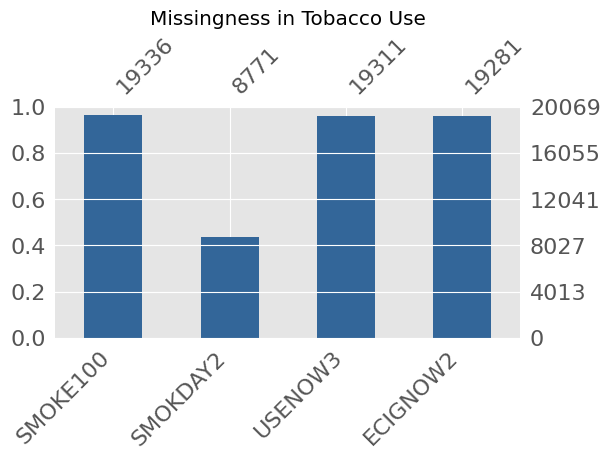

In [ ]:
col = get_existing_cols(df2, sections, 'Tobacco_Use')
msno.bar(df2[col],
         figsize=(6, 3),
         color=(0.2, 0.4, 0.6)
)
plt.title("Missingness in Tobacco Use")
plt.show()

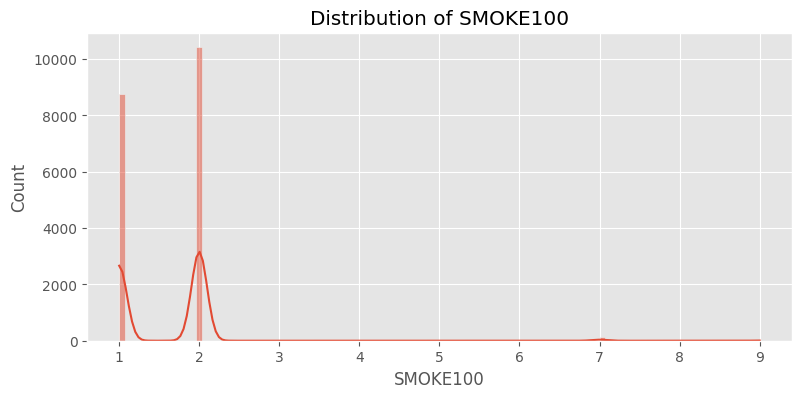

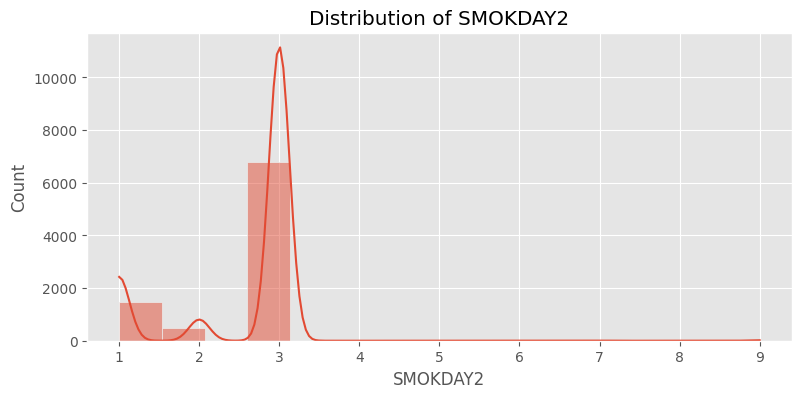

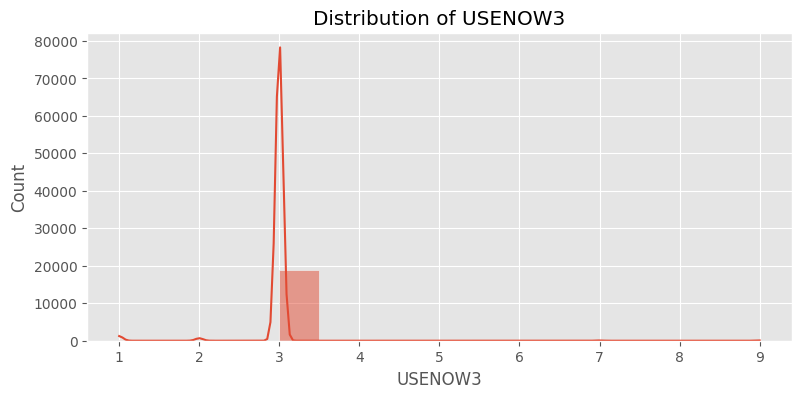

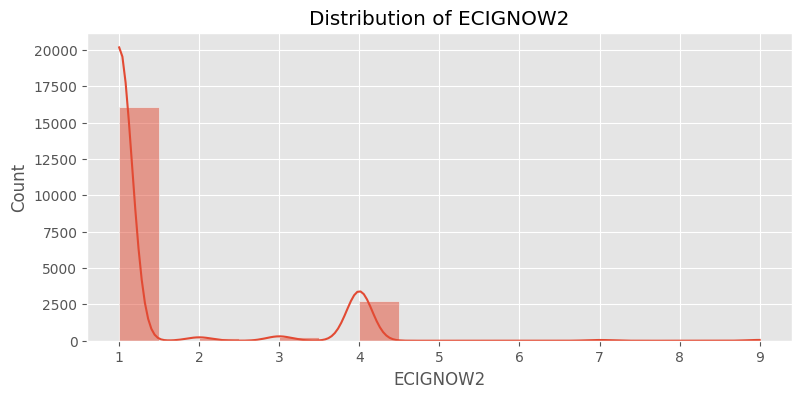

In [ ]:
plt.style.use('ggplot')
for column in filter:
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df4[column], kde = True)
    plt.title(f'Distribution of {column}')
    plt.show()

### Demographics

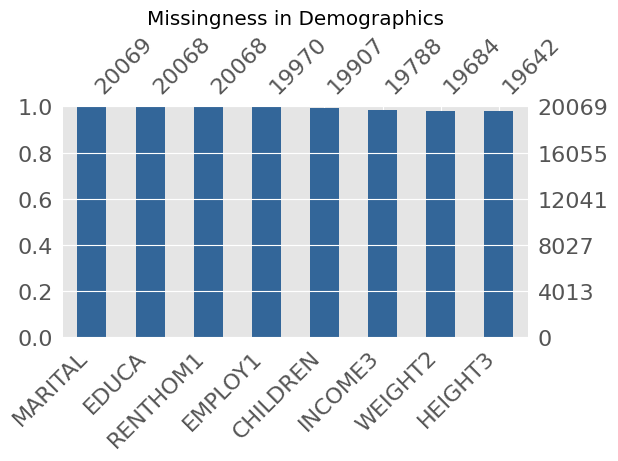

In [ ]:

col = get_existing_cols(df4, sections, 'Demographics')
msno.bar(df2[col],
         figsize=(6, 3),
         color=(0.2, 0.4, 0.6)
)
plt.title("Missingness in Demographics")
plt.show()

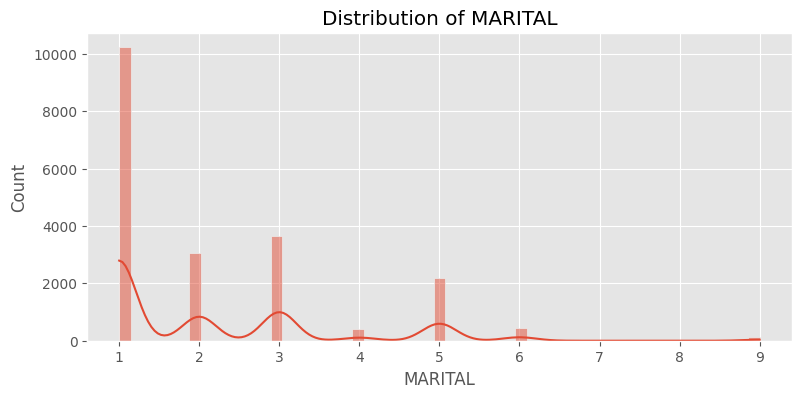

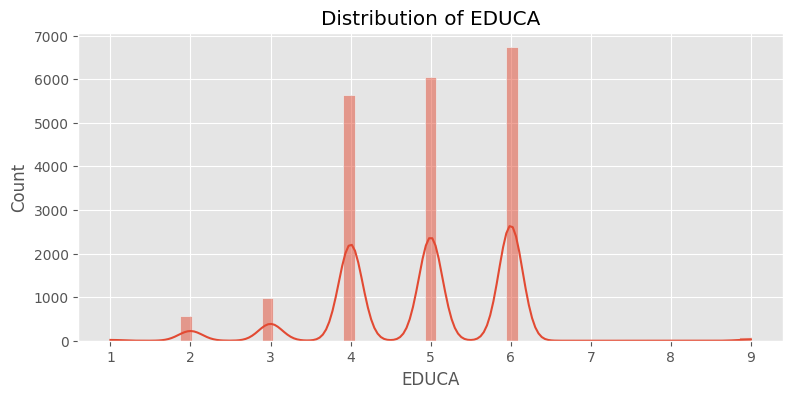

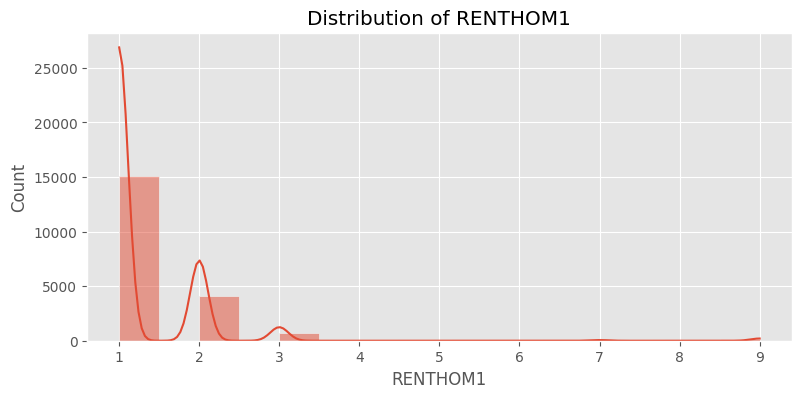

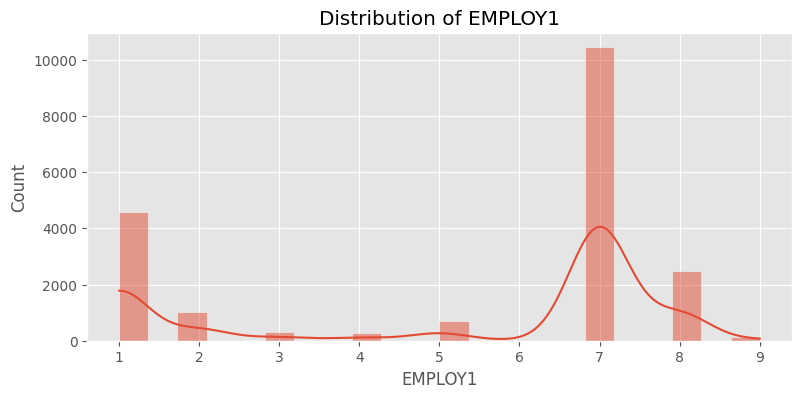

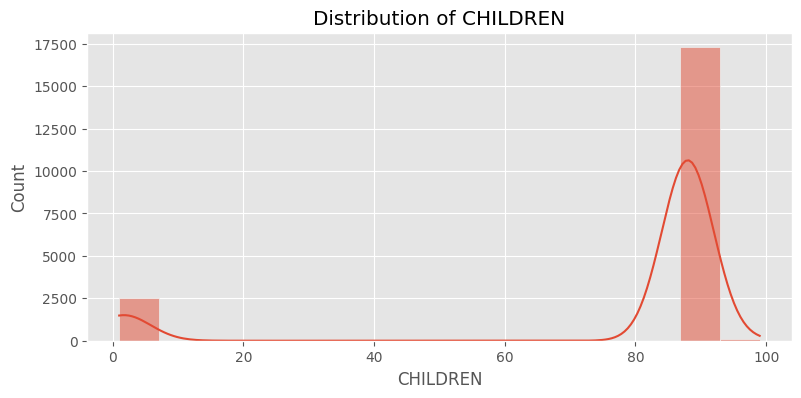

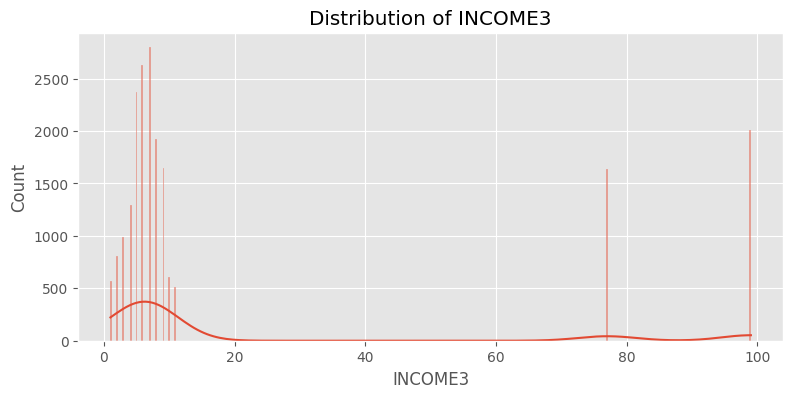

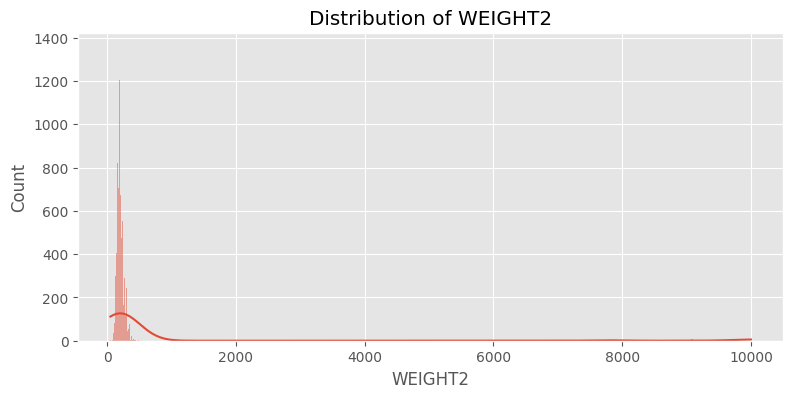

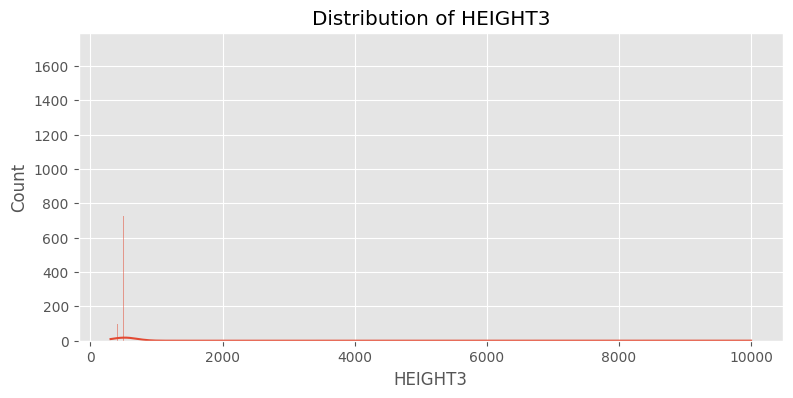

In [ ]:
dem_filter = get_existing_cols(df4, sections, 'Demographics')
plt.style.use('ggplot')
for column in dem_filter:
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df4[column], kde = True)
    plt.title(f'Distribution of {column}')
    plt.show()

Children look odd because 88 = "none" and 99 = "Refused".

In [ ]:
#dataquality report

dq_demographics = dqr(df4, dem_filter)
dq_demographics

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Std Dev
0,MARITAL,20069,0,7,1.0,1.0,2.167622,1.0,3.0,9.0,1.540920
1,EDUCA,20068,1,7,1.0,4.0,4.878114,5.0,6.0,9.0,1.071609
2,RENTHOM1,20068,1,5,1.0,1.0,1.331025,1.0,1.0,9.0,0.812397
3,EMPLOY1,19970,99,9,1.0,2.0,5.324387,7.0,7.0,9.0,2.724599
4,CHILDREN,19907,162,14,1.0,88.0,77.089114,88.0,88.0,99.0,28.755302
5,INCOME3,19788,281,13,1.0,5.0,21.433899,7.0,9.0,99.0,32.565923
6,WEIGHT2,19684,385,375,50.0,170.0,732.902357,200.0,240.0,9999.0,2159.071853
7,HEIGHT3,19642,427,80,305.0,504.0,727.078760,507.0,510.0,9999.0,1336.790926


## Feature Engineering Recommendations

1. 'Chronic_Health_Conditions'  and 'needs to be converted into a Diabetes Co-morbidity Score. Something that would score how severe their comorbidities are.
2. We should have a Diabetic Care score from the 'Diabetes' section.
3. We should create a disability indicator from the "disability" section.
4. We should create some sort of score from COVID Vacccination, Immunization, HPV_Vaccination, Tetanus & Healthcare_Access. Basically indicating if they have the ability to get proactive care or are actively getting proactive care.
5. Drinking & driving (Seatbelt use/drinking and driving) and Alcohol should be combined to create some sort of alcohol abuse indicator.
6. Height & Weight should be combined for a BMI indicator. See Note below about weight & height
7. Create a regional indicator based on _STATE
*All other sections remaining but not mentioned, we should consider combining  within that section to create some sort of indicator*

**WEIGHT**
See image below explaining how the weight feature works. We would need to do some cleaning before BMI conversion.

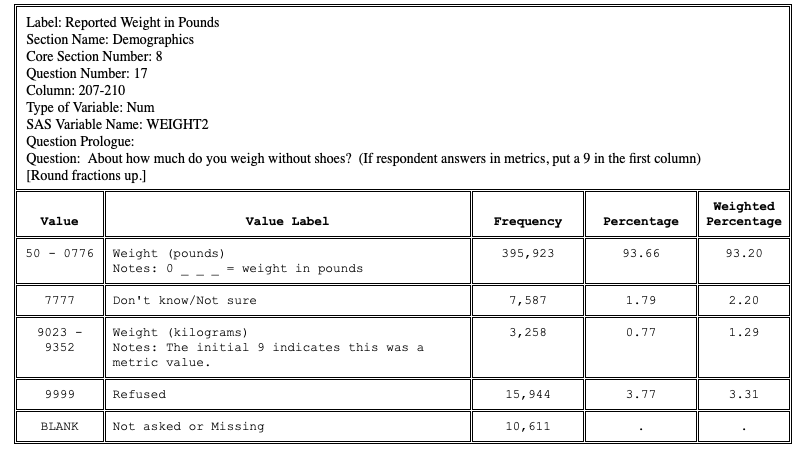

HEIGHT

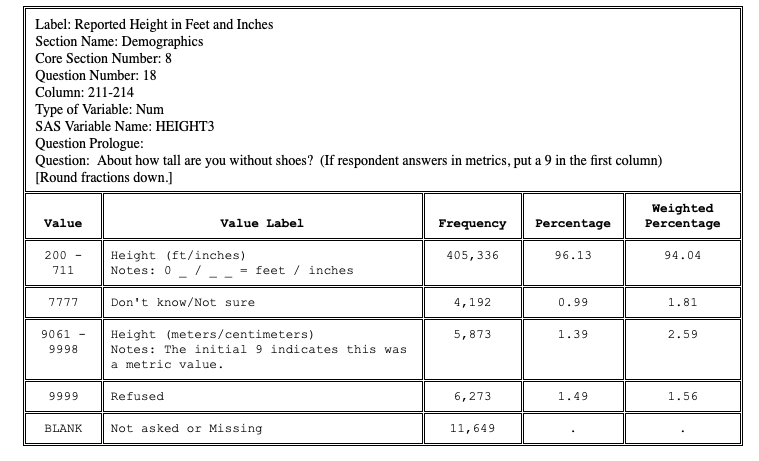